https://analyticsindiamag.com/semantic-segmentation-using-tensorflow-keras/

https://github.com/RajkumarGalaxy/ComputerVision/blob/master/get-started-with-semantic-segmentation-in-tf-keras.ipynb

In [6]:
 import numpy as np
 import tensorflow as tf
 from tensorflow import keras
 import cv2
 from scipy import io
 import tensorflow_datasets as tfds
 import matplotlib.pyplot as plt 

In [7]:
!pip install tensorflow_datasets

## Prepare Segmentation Dataset

In [8]:
!pwd

/Users/danielastuermer/neuefische/CapstoneProject_SteelDefectDetection/data


In [9]:
import os
#os.getcwd()
os.chdir('/Users/danielastuermer/neuefische/CapstoneProject_SteelDefectDetection/data/')

In [10]:
!cd ..

In [11]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [12]:
!ls clothing-co-parsing/

LICENSE           annotations       label_list.mat    show_image_anno.m
README.md         example.jpg       photos            show_pixel_anno.m


In [13]:
#Input images are in the photos directory, and labelled images are in the annotations directory. 
#Let’s extract the input images from the respective source directory.
images = []
for i in range(1,1001):
    url = './clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

Metal device set to: Apple M1


2022-02-14 10:25:00.598050: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-14 10:25:00.598195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
masks = []
for i in range(1,1001):
    url = './clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask) 

In [15]:
len(images), len(masks)

(1000, 1000)

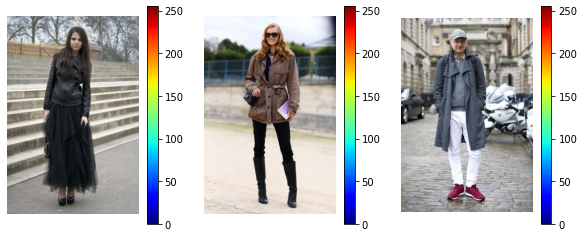

In [16]:

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show() 

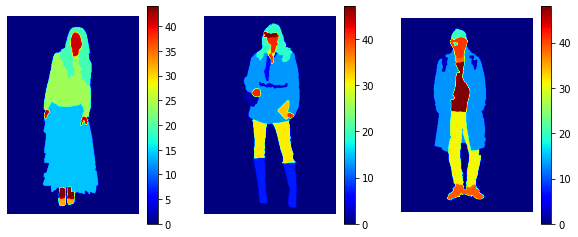

In [17]:
#We need to scale images and resize them to some common shape. Let’s visualize label images corresponding to the above input images.
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

Each colour in the above images refer to a specific class. We observe that the person and her/his wearings are segmented, leaving the surrounding unsegmented.

In [18]:
#The label values start at 0 and go all the way through 59.
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

## Model Selection

We enter into deep learning now. We have to build a computer vision model that can convert an input image into a segmented image (also called masked image or label image). Building a model from scratch and training it is not a good idea as we have very limited data for training (1000 images are insufficient for 59 unbalanced classes). So we prefer a pre-trained model through transfer learning.

By understanding how semantic segmentation works, we can easily come up with an idea of how to choose our pre-trained model. One of the popular architectural approaches is FCNN (Fully Convolutional Neural Networks). In contrast to CNNs in image classification, where the decision head is made up of dense layers, an FCNN is made up of layers related to convolutional operations only. Because the final output is an image of a shape identical to the input image. 

An FCNN contains two parts: an encoder and a decoder. An encoder is a downstack of convolutional neural layers that extract features from the input image. A decoder is an upstack of transpose convolutional neural layers that builds the segmented image from the extracted features. The sizes of feature maps go down while downsampling (e.g. 128, 64, 32, 16, 8, 4 – in order), and they go up while upsampling (e.g. 4, 8, 16, 32, 64, 128 – in order). Among FCNNs, U-Net is one of the successful architectures acclaimed for its performance in Medical Image Segmentation. It encourages skip connections between a few specific-sized layers of downstack and upstack. Skip-connections yield better performance because of the truth that upstack struggles to build finer details of the image on its own during upsampling. Skip-connections bye-pass a large stack of layers to feed finer details from a downstack layer to its corresponding upstack layer.
Original U-Net architecture for Medical Image Segmentation (source)

Here, we wish to use the functional approach of U-Net architecture, but we will have our own architecture suitable to our task. The downstack can be a pre-trained CNN, trained for image classification (e.g. MobileNetV2, ResNet, NASNet, Inception, DenseNet, or EfficientNet). It can effectively extract the features. But, we have to build our upstack to match our classes (here, 59), build skip-connections, and train it with our data. 

We prefer a pre-trained DenseNet121 to be the downstack that can be obtained through transfer learning and build the upstack with pix2pix, a publicly available generative upstack template (it saves our time and code).

## Build Downstack

In [19]:
#Load DenseNet121 from in-built applications.
base = keras.applications.DenseNet121(input_shape=[128,128,3], 
                                       include_top=False, 
                                       weights='imagenet')

In [20]:
len(base.layers)

427

In [21]:
!pip install pydot

In [22]:
!brew install graphviz

Running `brew update --preinstall`...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> Updated Formulae
Updated 19 formulae.
==> Updated Casks
Updated 24 casks.

To reinstall 2.50.0, run:
  brew reinstall graphviz


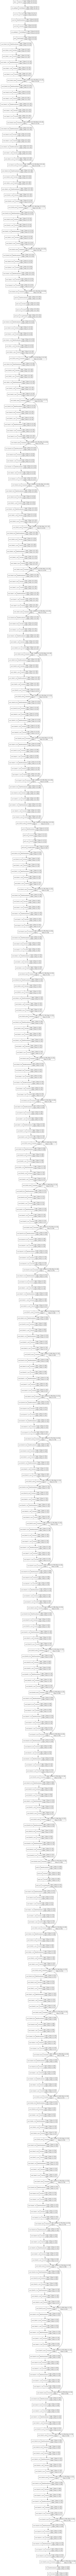

In [23]:
#The DenseNet121 model has 427 layers. We need to identify suitable layers whose output will be used for skip connections. 
#Plot the entire model, along with the feature shapes.
keras.utils.plot_model(base, show_shapes=True)

In [24]:
#We select the final ReLU activation layer for each feature map size, i.e. 4, 8, 16, 32, and 64, required for skip-connections. 
#Write down the names of the selected ReLU layers in a list.
skip_names = ['conv1/relu', # size 64*64
              'pool2_relu',  # size 32*32
              'pool3_relu',  # size 16*16
              'pool4_relu',  # size 8*8
              'relu'        # size 4*4
              ]

In [25]:
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [26]:
#Build the downstack with the above layers. We use the pre-trained model as such, without any fine-tuning.
downstack = keras.Model(inputs=base.input,
                        outputs=skip_outputs)
downstack.trainable = False

## Build Upstack Model

In [27]:
#Build the upstack using an upsampling template.
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
# Four upstack blocks for upsampling sizes 
# 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
           pix2pix.upsample(256,3),
           pix2pix.upsample(128,3),
           pix2pix.upsample(64,3)]

In [28]:
upstack[0].layers

In [29]:
#Build a U-Net model by merging downstack and upstack with skip-connections.
# define the input layer
inputs = keras.layers.Input(shape=[128,128,3])
# downsample 
down = downstack(inputs)
out = down[-1]
# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8
#upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])
# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                   strides=2,
                                   padding='same',
                                   )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

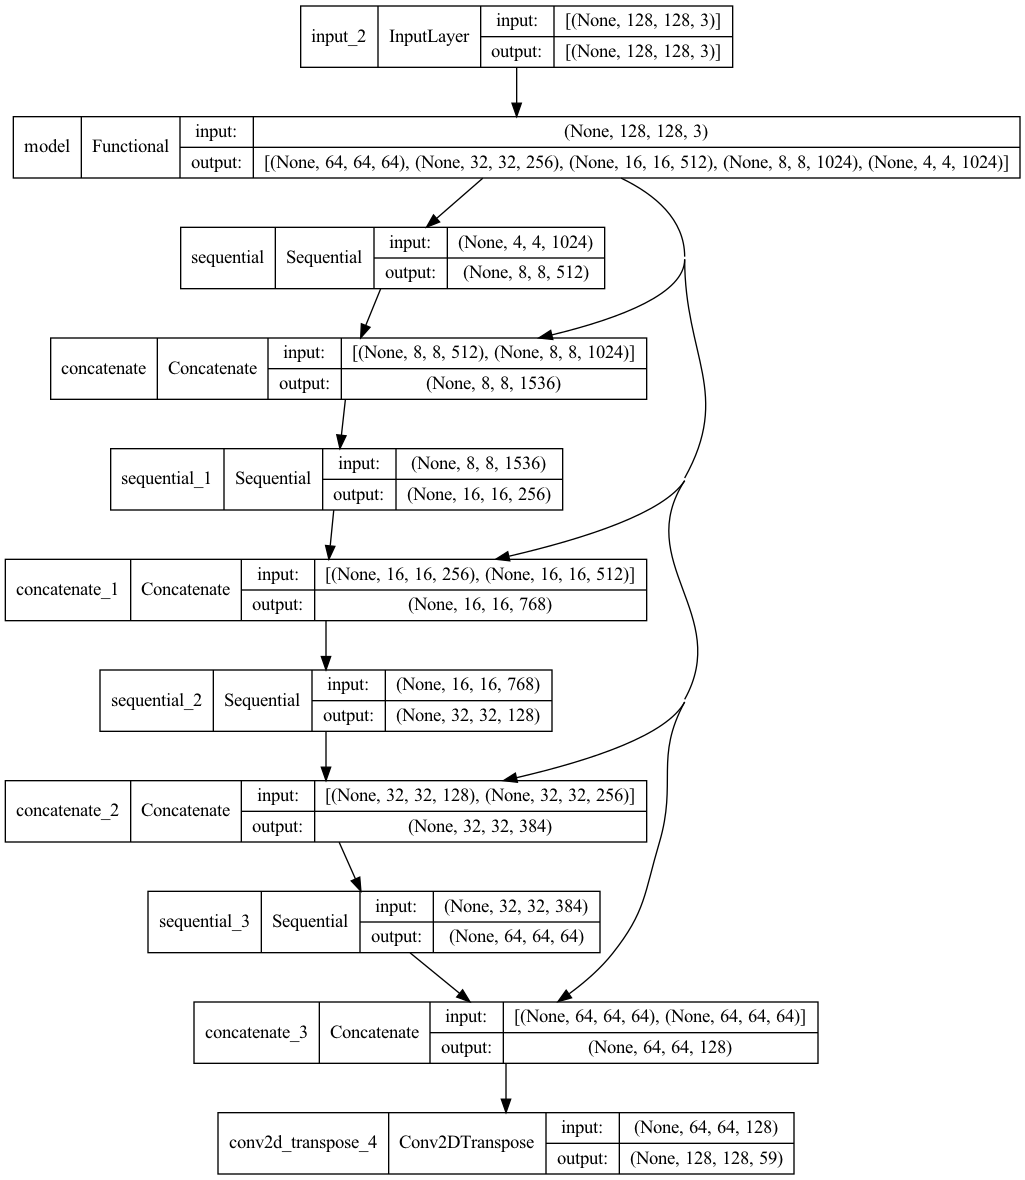

In [30]:
keras.utils.plot_model(unet, show_shapes=True)

## Preprocess Data

In [31]:
#Since we have limited images, we prepare more data through augmentation.
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image 
def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask

In [32]:
#Resize images and masks to the size 128 by 128.
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]

In [33]:
#We have 800 train examples. That’s too low for training. 
#We define a couple of augmentation functions to generate more train examples.
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [34]:
from sklearn.model_selection import train_test_split

train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                      test_size=0.2, 
                                                      random_state=0
                                                     )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)

train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)

train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [35]:
#Zip input images and ground truth masks. 

train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y)) 

In [36]:
#Apply augmentation to the data with the above functions. 
#With 7 augmentation functions and 800 input examples, we can get 7*800 = 5600 new examples. 
#Including original examples, we get 5600+800 = 6400 examples for training. That sounds good!


# perform augmentation on train data only
a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [37]:
#Prepare data batches. Shuffle the train data.

BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

## Train the model

2022-02-14 10:25:32.503095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-14 10:25:32.531954: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


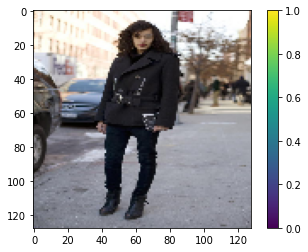

In [38]:
#Let’s check whether everything is good with the data and the model by sampling one example image and predict it with the untrained model.

example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

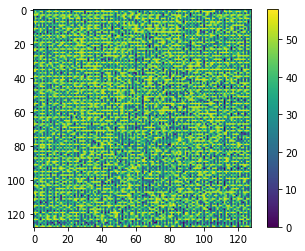

In [39]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

In [40]:
#Compile the model with RMSprop optimizer, 
#Sparse Categorical Cross-entropy loss function and accuracy metric. Train the model for 20 epochs.
unet.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(lr=0.001),
            metrics=['accuracy']) 

/Users/danielastuermer/neuefische/CapstoneProject_SteelDefectDetection/.venv/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [42]:
hist = unet.fit(train,
               validation_data=val,
               steps_per_epoch=STEPS_PER_EPOCH,
               validation_steps=VALIDATION_STEPS,
               epochs=10)

Epoch 1/10
12/12 [==============================] - 18s 2s/step - loss: 0.5347 - accuracy: 0.8549 - val_loss: 0.7201 - val_accuracy: 0.8141
Epoch 2/10
12/12 [==============================] - 21s 2s/step - loss: 0.5845 - accuracy: 0.8427 - val_loss: 0.6528 - val_accuracy: 0.8299
Epoch 3/10
12/12 [==============================] - 21s 2s/step - loss: 0.5542 - accuracy: 0.8500 - val_loss: 0.6549 - val_accuracy: 0.8287
Epoch 4/10
12/12 [==============================] - 22s 2s/step - loss: 0.7683 - accuracy: 0.8034 - val_loss: 0.6145 - val_accuracy: 0.8405
Epoch 5/10
12/12 [==============================] - 22s 2s/step - loss: 0.7310 - accuracy: 0.8101 - val_loss: 0.6085 - val_accuracy: 0.8384
Epoch 6/10
12/12 [==============================] - 23s 2s/step - loss: 0.6622 - accuracy: 0.8243 - val_loss: 0.6299 - val_accuracy: 0.8316
Epoch 7/10
12/12 [==============================] - 24s 2s/step - loss: 0.6348 - accuracy: 0.8318 - val_loss: 0.6153 - val_accuracy: 0.8385
Epoch 8/10
12/12 [==

## Performance Evaluation /Prediction

2022-02-14 10:35:39.426651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


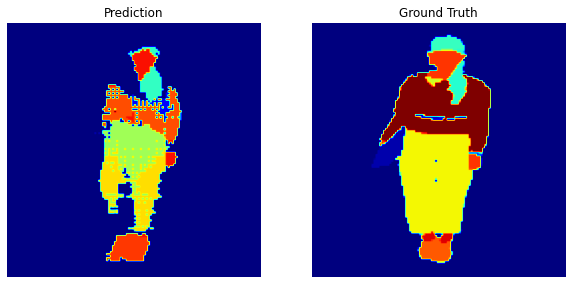

In [43]:
img, mask = next(iter(val))
pred = unet.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break
plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

## Performance Curves

In [ ]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()